In [1]:
"""
# Housing Price Correlation Analysis
# Author: Aditya Girish Mogadpally
# Date: April 16, 2025
#
# This script performs statistical correlation analysis on the Housing Prices dataset from Kaggle.
# It includes data exploration, visualization, and correlation analysis.
"""

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')



In [2]:
url = "/content/Housing.csv"
df = pd.read_csv(url)

In [3]:
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset Shape: (545, 13)
Columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"\nColumns with missing values:")
print(missing_values[missing_values > 0])


Columns with missing values:
Series([], dtype: int64)


In [5]:
# Basic data handling - fill missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown', inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Convert categorical variables to numerical
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category').cat.codes


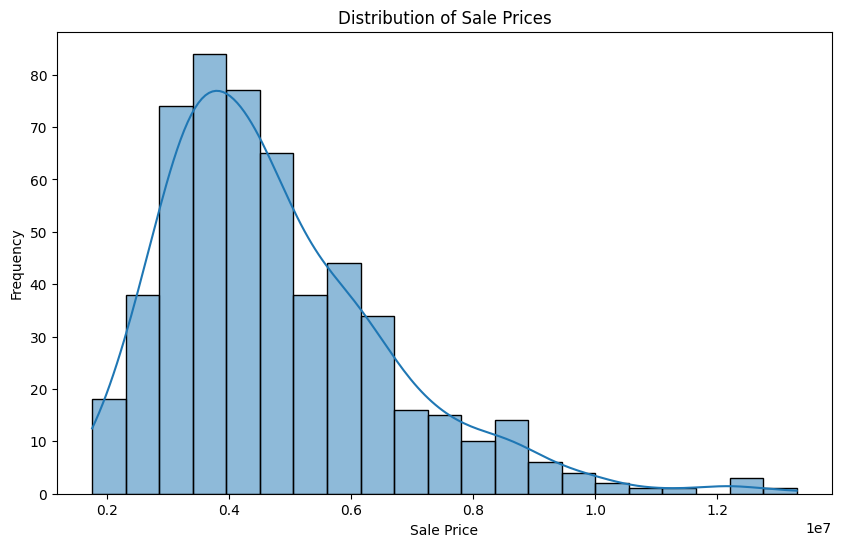

In [6]:
# Plot distribution of the price
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()


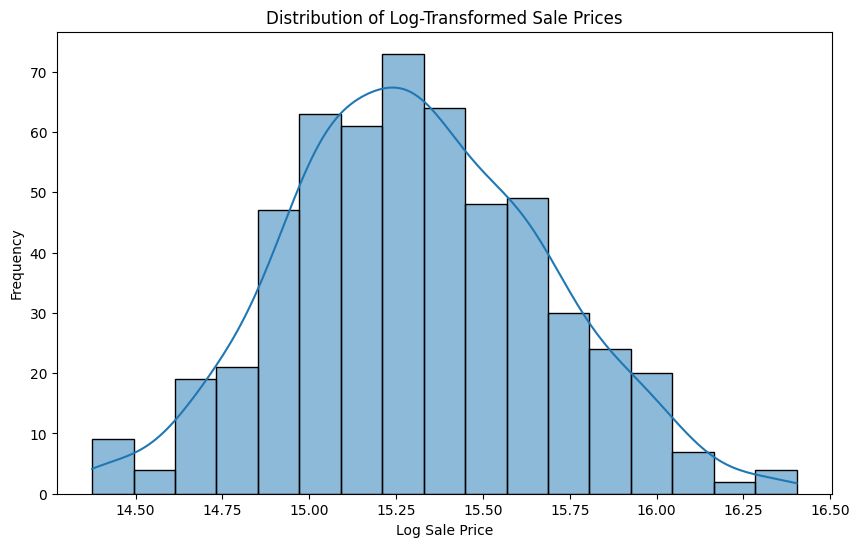

In [7]:
# Log transform the target for better distribution
df['LogPrice'] = np.log1p(df['price'])
plt.figure(figsize=(10, 6))
sns.histplot(df['LogPrice'], kde=True)
plt.title('Distribution of Log-Transformed Sale Prices')
plt.xlabel('Log Sale Price')
plt.ylabel('Frequency')
plt.savefig('log_saleprice_distribution.png')
plt.show()

In [8]:
# Correlation Analysis
print("\n--- Correlation Analysis ---")

# Calculate correlation with target variable
correlation_with_price = df.corr()['price'].sort_values(ascending=False)
print("\nTop 10 Features Correlated with price:")
print(correlation_with_price[:11])  # Including SalePrice itself


--- Correlation Analysis ---

Top 10 Features Correlated with price:
price              1.000000
LogPrice           0.969010
area               0.535997
bathrooms          0.517545
airconditioning    0.452954
stories            0.420712
parking            0.384394
bedrooms           0.366494
prefarea           0.329777
mainroad           0.296898
guestroom          0.255517
Name: price, dtype: float64


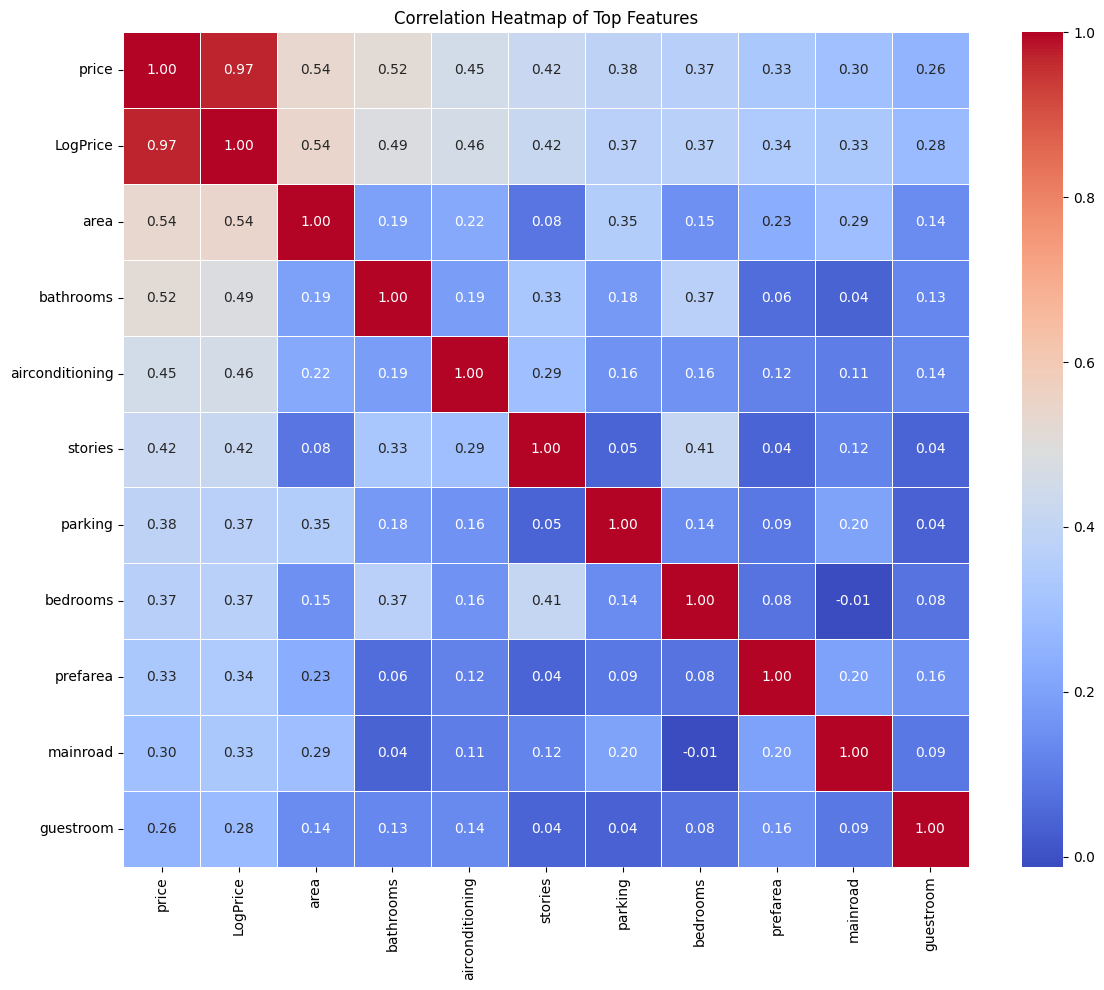

In [9]:
# Create correlation heatmap for top features
top_features = correlation_with_price[:11].index.tolist()
correlation_matrix = df[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.show()

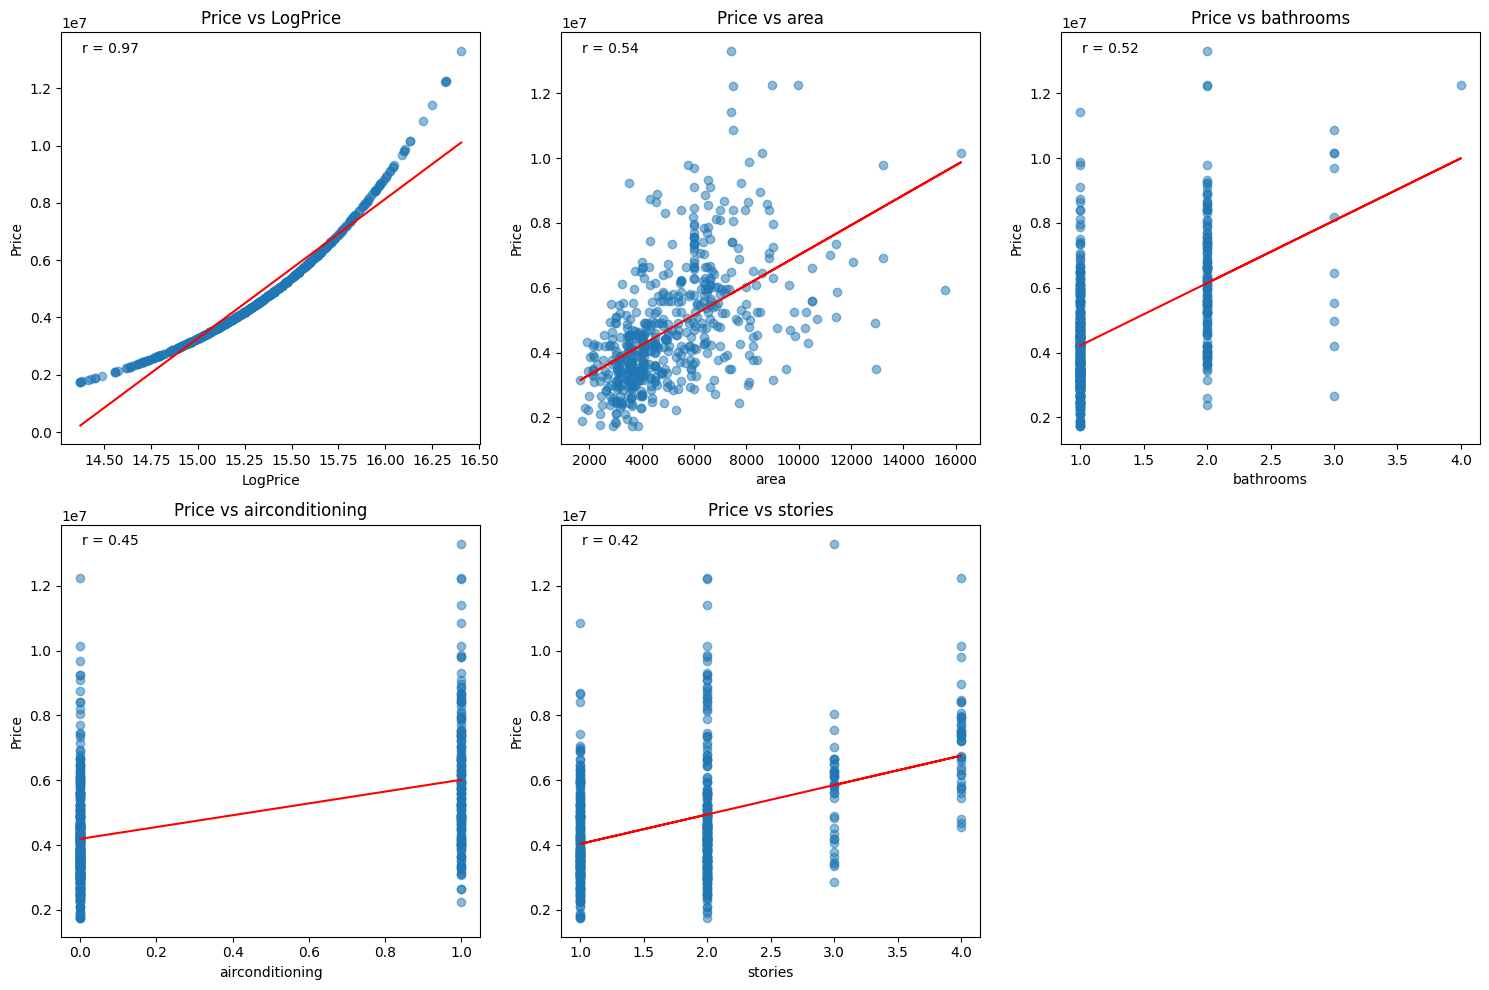

In [10]:
# Scatter plots of top 5 correlated features with SalePrice
top5_features = correlation_with_price[1:6].index.tolist()  # Excluding SalePrice itself

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top5_features):
    plt.subplot(2, 3, i+1)
    plt.scatter(df[feature], df['price'], alpha=0.5)
    plt.title(f'Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Price')

    # Add regression line
    m, b = np.polyfit(df[feature], df['price'], 1)
    plt.plot(df[feature], m*df[feature] + b, color='red')

    # Add correlation coefficient in the plot
    corr = df['price'].corr(df[feature])
    plt.annotate(f'r = {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()


<Figure size 1200x1000 with 0 Axes>

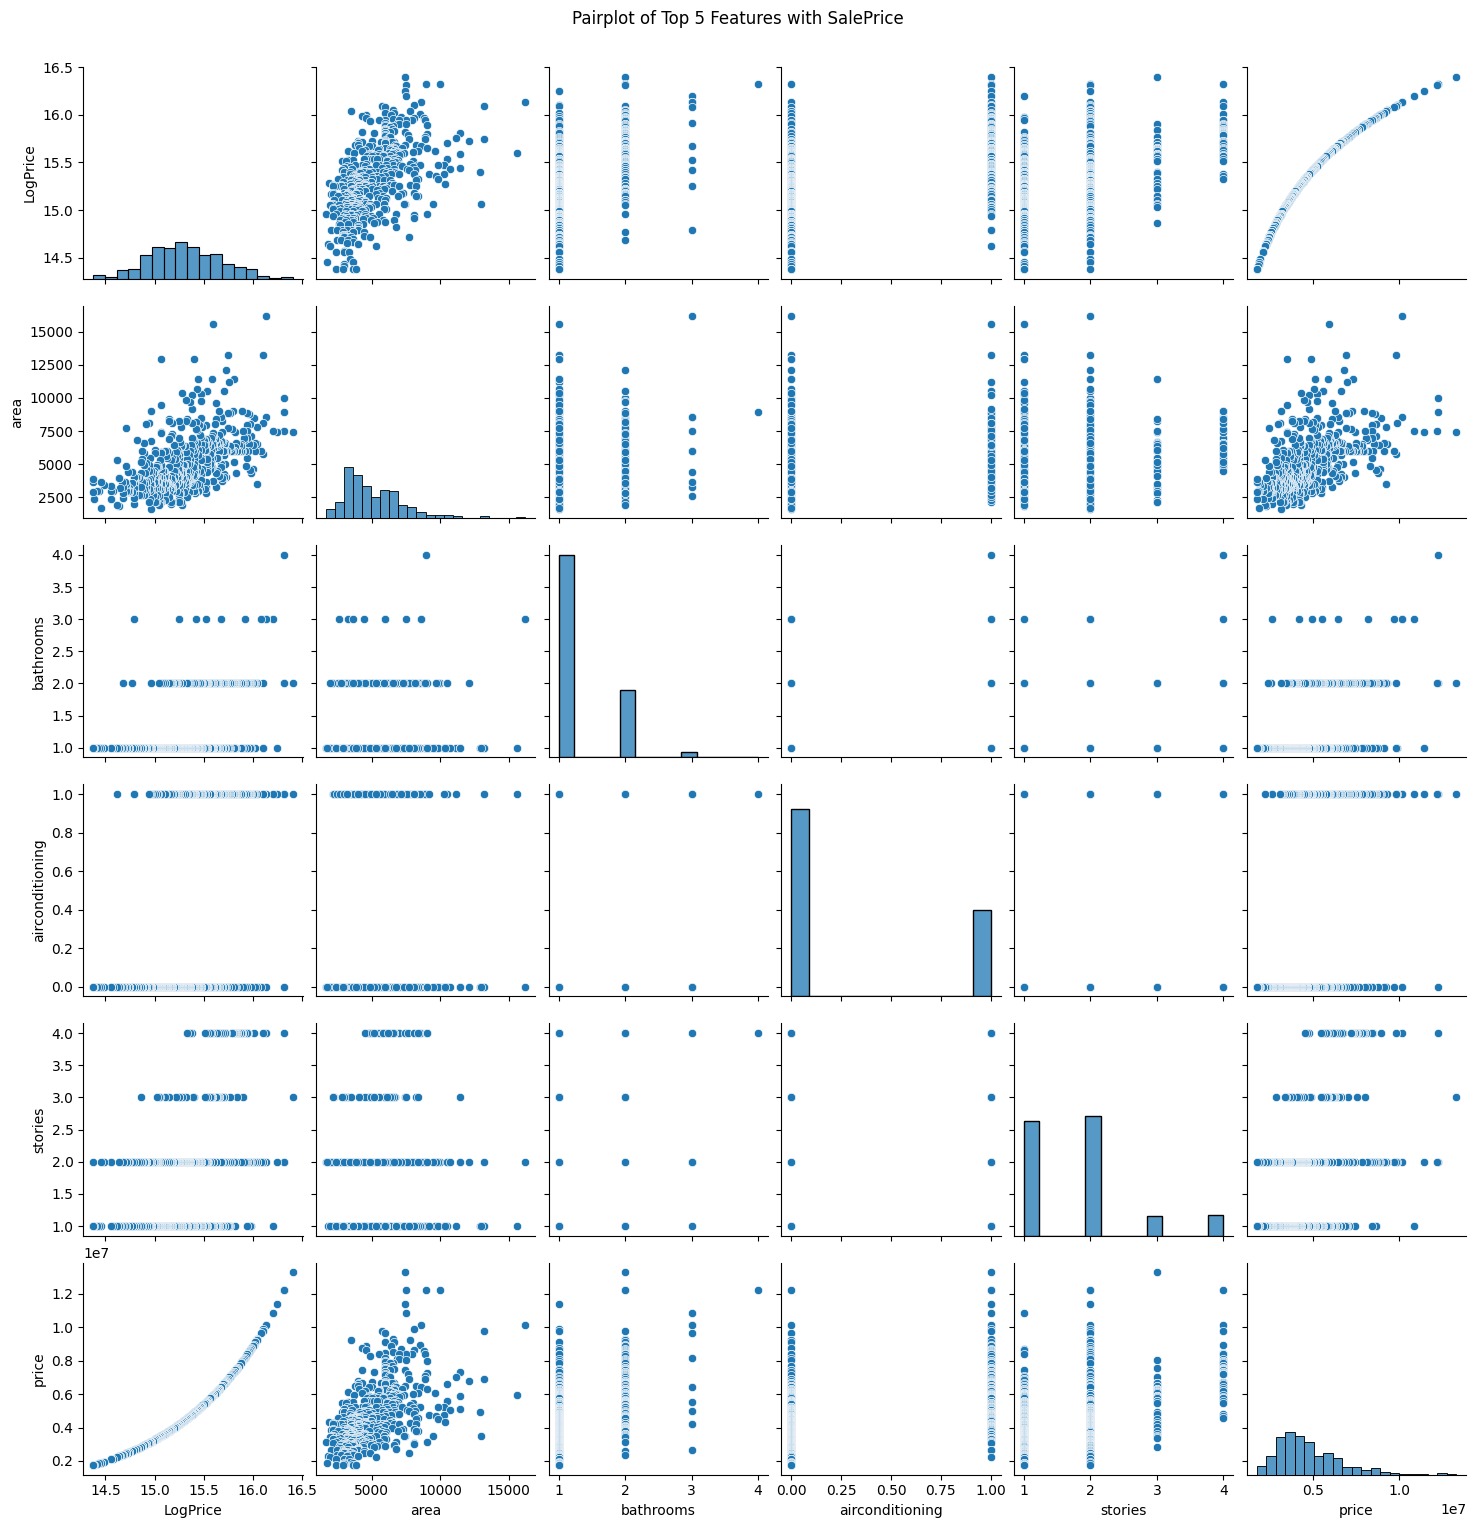

In [11]:
# Pairplot for deeper analysis
plt.figure(figsize=(12, 10))
sns.pairplot(df[top5_features + ['price']])
plt.suptitle('Pairplot of Top 5 Features with SalePrice', y=1.02)
plt.show()

In [12]:
# Different correlation methods comparison
print("\n--- Comparing Different Correlation Methods ---")

# Calculate correlations using different methods
pearson = df[top5_features + ['price']].corr(method='pearson')['price'].sort_values(ascending=False)
spearman = df[top5_features + ['price']].corr(method='spearman')['price'].sort_values(ascending=False)
kendall = df[top5_features + ['price']].corr(method='kendall')['price'].sort_values(ascending=False)

# Create a comparison dataframe
correlation_comparison = pd.DataFrame({
    'Pearson': pearson,
    'Spearman': spearman,
    'Kendall': kendall
})

print("\nCorrelation Methods Comparison for Top Features:")
print(correlation_comparison)


--- Comparing Different Correlation Methods ---

Correlation Methods Comparison for Top Features:
                  Pearson  Spearman   Kendall
LogPrice         0.969010  1.000000  1.000000
airconditioning  0.452954  0.457100  0.374885
area             0.535997  0.602859  0.422227
bathrooms        0.517545  0.479912  0.393023
price            1.000000  1.000000  1.000000
stories          0.420712  0.362856  0.286133


<Figure size 1200x800 with 0 Axes>

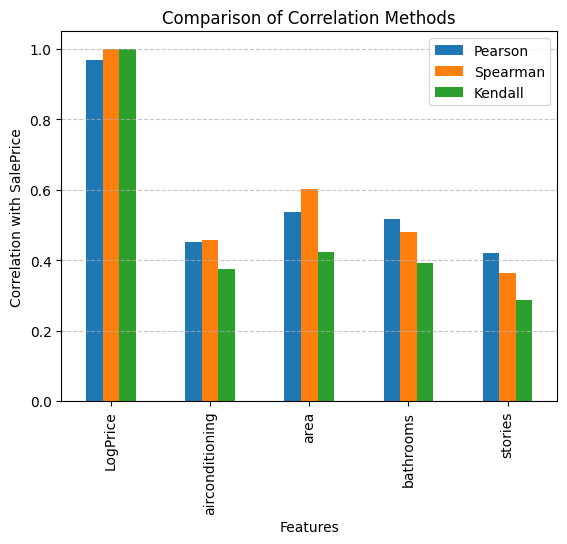

In [13]:
# Plot the comparison
plt.figure(figsize=(12, 8))
correlation_comparison.drop('price').plot(kind='bar')
plt.title('Comparison of Correlation Methods')
plt.ylabel('Correlation with SalePrice')
plt.xlabel('Features')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
# Feature pair correlations
print("\n--- Analyzing Feature Pair Correlations ---")

# Find highly correlated feature pairs
feature_corr = df.corr().abs()
upper_tri = feature_corr.where(np.triu(np.ones(feature_corr.shape), k=1).astype(bool))
high_corr_pairs = [(upper_tri.index[i], upper_tri.columns[j], upper_tri.iloc[i, j])
                   for i in range(len(upper_tri.index))
                   for j in range(len(upper_tri.columns))
                   if upper_tri.iloc[i, j] > 0.7]

print("\nHighly Correlated Feature Pairs (r > 0.7):")
for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
    print(f"{feat1} & {feat2}: {corr:.3f}")


--- Analyzing Feature Pair Correlations ---

Highly Correlated Feature Pairs (r > 0.7):
price & LogPrice: 0.969


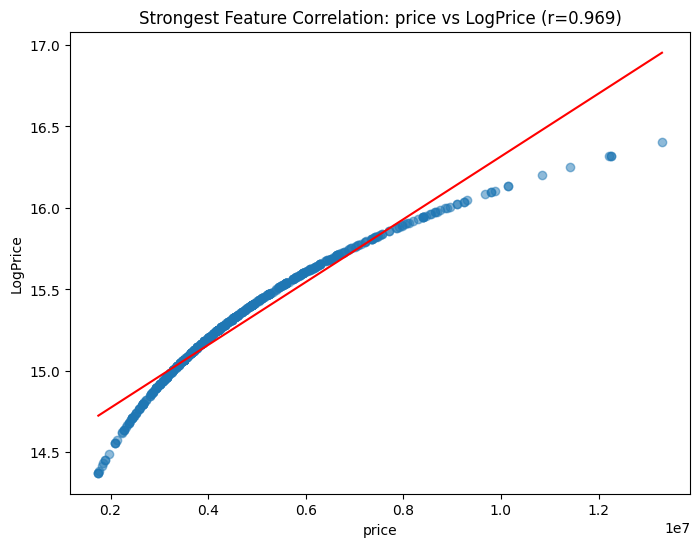

In [15]:
# Visualize the strongest pair correlation
if high_corr_pairs:
    strongest_pair = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)[0]
    feat1, feat2, corr = strongest_pair

    plt.figure(figsize=(8, 6))
    plt.scatter(df[feat1], df[feat2], alpha=0.5)
    plt.title(f'Strongest Feature Correlation: {feat1} vs {feat2} (r={corr:.3f})')
    plt.xlabel(feat1)
    plt.ylabel(feat2)

    # Add regression line
    m, b = np.polyfit(df[feat1], df[feat2], 1)
    plt.plot(df[feat1], m*df[feat1] + b, color='red')

    plt.show()

In [16]:
# Basic predictive modeling to validate correlations
print("\n--- Basic Predictive Modeling ---")

# Prepare data for modeling
X = df[top5_features]
y = df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

# Train random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print(f"\nLinear Regression (top 5 features):")
print(f"R² Score: {lr_r2:.4f}")
print(f"RMSE: ${lr_rmse:.2f}")

print(f"\nRandom Forest (top 5 features):")
print(f"R² Score: {rf_r2:.4f}")
print(f"RMSE: ${rf_rmse:.2f}")


--- Basic Predictive Modeling ---

Linear Regression (top 5 features):
R² Score: 0.9277
RMSE: $604556.08

Random Forest (top 5 features):
R² Score: 0.9947
RMSE: $163143.29


In [17]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': top5_features,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

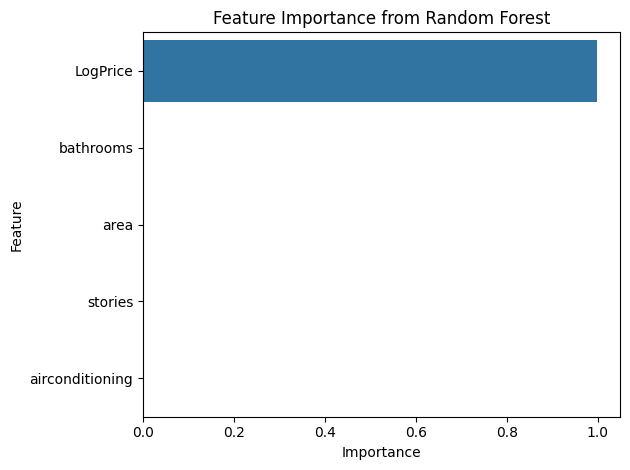


Feature Importance:
           Feature  Importance
0         LogPrice    0.998601
2        bathrooms    0.000609
1             area    0.000538
4          stories    0.000178
3  airconditioning    0.000074


In [18]:
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()
print("\nFeature Importance:")
print(feature_importance)

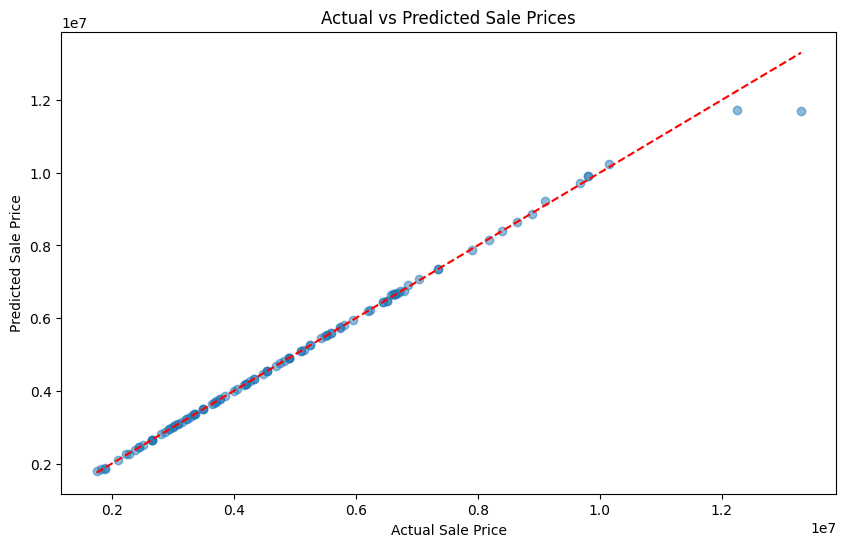

In [20]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Prices')
plt.show()


--- Analysis Summary ---
1. Top correlated feature with SalePrice: LogPrice (r=0.969)
2. Random Forest model achieved R² of 0.9947 using only top 5 correlated features
3. Most important feature according to Random Forest: LogPrice
4. 1 pairs of features showed strong correlation (r > 0.7)

This analysis demonstrates the strong relationships between housing attributes and sale prices.
